## Scrape data

In [353]:
'''
Imports modules and libraries needed for web scraping! 
'''
import time #for pausing the scrap
from bs4 import BeautifulSoup #for reading and parsing html
import requests #for requesting a link's html code
from tqdm import tqdm #for progress bar to keep track of iterator time estimate
getattr(tqdm, '_instances', {}).clear()
import re #regular expression for cleaning text
from nltk.tokenize import word_tokenize #for tokenising string into bag of words!

# for wordcloud
from wordcloud import WordCloud
from bidi.algorithm import get_display

# general
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt

# identification to scraped websites
headers = {"user-agent" : "Chrome/84.6.35.5045 (Windows NT 10.0; Win64; x64)",
            "from": "Student at Minerva working on a university project.)"}

  7%|▋         | 14/211 [318:44:49<4485:13:40, 81963.56s/it]


In [382]:
'''
This code goes through a webpage of Walla news archive in the format
'https://news.walla.co.il/archive/1?year=2020&month=3&page=1' after it was parsed by BeautifulSoup
and extracts the titles, subtitles, reporter, date, and links of all 50 articles in the page.
'''

def extract_titles(soup): 

    # an array that will contain all new articles for the page
    page_rows = []
    
    # find the part of the page with all article links
    all_content = soup.find("div", class_="css-18xwv1d")

    # get all links to items
    all_links = all_content.find_all("a",href=True)
    link_urls = [l['href'] for l in all_links]
        
    # Look into all article 'boxes' in the page
    all_groupings = all_content.find_all("div", class_="content")

    # for each article
    for i, grouping in enumerate(all_groupings):
        # get title, subtitle, reporter name, and date publisjed
        title = grouping.find("h3").get_text()
        subtitle = grouping.find("p").get_text()
        reporter = grouping.find('div', class_='author').get_text()
        date = grouping.find('div', class_='pub-date').get_text()
        
        # make a data dictionary that will be written into the csv
        row = { "date": date,
                "title": title,
                "subtitle": subtitle,
                "reporter": reporter,
                "link": link_urls[i]}
        
        # fix the first row's reporter name which is not extracted simply by using the get text on the div
        if i==0:
            row['reporter'] = ''.join(e for e in t if (e==' ' or (not e.islower() and e.isalnum() and not e.isnumeric())))
        
        page_rows.append(row)
        
    return(page_rows)

In [383]:
'''
This code finds all of the news pages of a given year. Every page has 50 articles and
a link to the next page, except for the last one. This block of code visits the first
page of the category, scrapes it using the function above, then finds the link to the 
next page and visits it until all pages for that year are scraped.  
'''
# an array that will contain the scraped dataset
all_rows=[]

# an array to hold page URLs to visit
pages=[]

# A counter to monitor which URL should be visited next
counter = 0

# for each month
for m in tqdm(range(1,13)):
    # set up the first URL based on the month, page=1
    start_page = 'https://news.walla.co.il/archive/1?year=2019&month='+str(m)+'&page=1'
    
    # add it to the list of pages to scrape
    pages.append(start_page)
    
    while pages[counter]: # while there are still pages left to scrape

        # rest scraper for a long time to be safe
        time.sleep(11)

        # request the page html
        #print('scraping:', pages[counter])
        page = requests.get(pages[counter], headers= headers)
        soup = BeautifulSoup(page.content, "html.parser")
        
        # scrape info of articles on that apge
        new_rows = extract_titles(soup)
        all_rows += new_rows

        # find link to the next page
        next_ = soup.find("a", class_="next walla-icon-next")

        # if a link exists, add it to the list of pages to visit and up the counter
        if next_ is not None:
            next_page = next_['href']
            pages.append(next_page)
            counter += 1

        # else, break while loop if the page has no next page and move to next month
        else:
            counter+=1
            break

  8%|▊         | 1/12 [01:53<20:49, 113.63s/it]

starting a new month


 17%|█▋        | 2/12 [03:30<18:07, 108.71s/it]

starting a new month


 25%|██▌       | 3/12 [05:10<15:54, 106.03s/it]

starting a new month


 33%|███▎      | 4/12 [06:50<13:53, 104.24s/it]

starting a new month


 42%|████▏     | 5/12 [08:46<12:33, 107.60s/it]

starting a new month


 50%|█████     | 6/12 [10:43<11:03, 110.61s/it]

starting a new month


 58%|█████▊    | 7/12 [12:40<09:21, 112.32s/it]

starting a new month


 67%|██████▋   | 8/12 [14:22<07:17, 109.27s/it]

starting a new month


 75%|███████▌  | 9/12 [15:48<05:07, 102.50s/it]

starting a new month


 83%|████████▎ | 10/12 [17:46<03:34, 107.14s/it]

starting a new month


 92%|█████████▏| 11/12 [19:29<01:45, 105.82s/it]

starting a new month


100%|██████████| 12/12 [21:25<00:00, 107.15s/it]

starting a new month


In [384]:
#write list of dictionaries into a datafrme
new_df = pd.DataFrame(all_rows) 

# save to file
# pickle.dump(new_df, open( "2019data.p", "wb"))

# read from file 
# new_df = pd.read_pickle("./data/jan2020data.p") 

In [386]:
#preview!
new_df.tail()

,date,title,subtitle,reporter,link
4205,09:10 01/12/2019,עשרות טורבינות בגובה 200 מטר: התכנית שמאיימת ע...,ביישובים הדרוזים ברמת הגולן חוששים כי בישיבת ה...,אלי אשכנזי,https://news.walla.co.il/item/3326774
4206,08:55 01/12/2019,"תאונה קשה בגבעת זאב: אם ובתה התינוקת נהרגו, יל...","בתאונה הקשה בכביש 443, נהרגו ציפי בת ה-34 מנוו...","מאיה הורודניצ'אנו, בועז אפרת, לירן לוי ויואב א...",https://news.walla.co.il/item/3326732
4207,05:00 01/12/2019,"מעשנים הרבה, מתחסנים פחות: נתוני הבריאות של הי...",דוח המכון הלאומי לחקר מדיניות הבריאות מגלה שיפ...,בועז אפרת,https://news.walla.co.il/item/3326736
4208,05:00 01/12/2019,שנה שנייה ברציפות: עלייה במספר נשאי האיידס החד...,"לרגל יום האיידס הבינלאומי, חושף דוח משרד הבריא...",בועז אפרת,https://news.walla.co.il/item/3326735
4209,04:25 01/12/2019,"סערה מתקרבת: הגשמים ישובו לקראת הערב, חשש לשיט...","הטמפרטורות מתקררות לקראת יממה סוערת, ומה שיתחי...",יואב איתיאל,https://news.walla.co.il/item/3326740


### Add normalized words column per article

In [387]:
'''
get an array of normalized words without punctuation using the HebrewNLP API.
runtime for 300 articles: about 2 minutes. 
For 4210 took 2hours, but I didnt really need to rest it so would take much less.
'''

# an array that hold the new column with normalized words per article
words_column = []

ignore = ['מ#', # values returned by the API for numbers
         'ג#'] 

for i in tqdm(range(new_df.shape[0])): # iterate over all rows
    # rest API
    time.sleep(0.5)
    
    # create request object for API
    request = {
        'token': 'EGxhAVjlYSoRNsN',
        'readable': False,
        'paragraph':  new_df.title[i]+'. '+new_df.subtitle[i]
    }
    
    # get result from API
    result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

    # an array that will host all words in the text
    all_words =  []
    for sentence in result:
        for word in sentence:
            # word[0] is the API's best suggestion, 'baseWord' is the normalized word
            all_words.append(word[0]['baseWord']) 

    # remove numbers
    clean_words = [c for c in all_words if len(c)>1 and c not in ignore]
    joined = ' '.join(clean_words) # make into a long string for saving in the DF
    words_column.append(joined)
    
new_df.loc[:,'norm_words'] = words_column # create the new column

100%|██████████| 4210/4210 [2:35:08<00:00,  2.21s/it]  


#### Load saved data
after adding normalized words column via HebrewNLP API

In [3]:
# save to file
# pickle.dump(new_df, open( "2019data_norm.p", "wb"))

# read from file 
new_df = pd.read_pickle("./data/2019data_norm.p") 

In [4]:
# Preview again
new_df.head()

,date,title,subtitle,reporter,link,norm_words
0,19:38 31/01/2019,"מסתמן: היועמ""ש סיים לדון בתיקי נתניהו וימסור ב...","על פי הדיווחים במהדורות החדשות, מנדלבליט צפוי ...",בועז אפרת,https://news.walla.co.il/item/3216463,"הסתמנ היועמ""ש סיימ דנ תיק נתניהו מסר בקרוב את ..."
1,19:31 31/01/2019,עתירה נגד הרשות לפיתוח י-ם: מסתירה מידע חיוני ...,"ארגון ""עמק שווה"" ותושבים נוספים בעיר המתנגדים ...",מאיה הורודניצ'אנו,https://news.walla.co.il/item/3216441,עתיר נגד רשות פיתוח סתירה מידע חיוני על רכבל כ...
2,19:26 31/01/2019,"כייסים, שודדים ומתחזים: הכירו את תיירי הפשע שנ...",בבתי המעצר ברחבי הארץ יושבים כרגע עשרה תיירים ...,אבי אשכנזי,https://news.walla.co.il/item/3216429,כייס שודד התחזה הכיר את תייר פשע נחת ישראל בית...
3,18:32 31/01/2019,"""היא עצבנה אותי"": צעיר רצח את הכלב של חברתו שב...","המקרה הקשה התרחש בחיפה לפני כחודש, אך רק אתמול...",יואב איתיאל,https://news.walla.co.il/item/3216447,הוא עיצב את צעיר רצח את כלב של חברה ביקש נפרד ...
4,16:17 31/01/2019,"""דבר כמו במכות מצרים"": 5,000 כבשים ועזים נחשפו...",דוח של משרד החקלאות קבע כי מחלת הדבר התפרצה בע...,יואב איתיאל,https://news.walla.co.il/item/3216326,דבר כמו מכה מצרי כבש עז נחשפ מחלה הסגר דוח של ...


### Find sexaul assault related articles

So far we got all articles, now we want to extract only those related to the analysis.

In [5]:
'''get an array of normalized words that are indicative of sexual assault stories
   and compare it against the normalized words colunmn per article created above'''

relevant_words = 'פדופיליה פדופיל מין מיני מינית אינטימיים אונס מגונים מגונה סקס אנס נאנס נאנסה יחסים הטריד הטרדה שכב'
# I might remove two words here that made significant amount of noise 
# and might try adding them in conjuction with some other words.

# get the normalized version of these words to compare with the normalized words column
request = {
    'token': 'EGxhAVjlYSoRNsN',
    'readable': False,
    'paragraph':  relevant_words
}

test_result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# extract best guess for the normalized form of each word
sexual_assault_words =  []
for sentence in test_result:
    for word in sentence:
        sexual_assault_words.append(word[0]['baseWord'])
        
sexual_assault_words.remove('.') # remove period which gets added in automatically
print(sexual_assault_words) # the words

['פדופיליה', 'פדופיל', 'מינ', 'מיני', 'מינה', 'אינטימי', 'אונס', 'מגונה', 'גונה', 'סקס', 'אנס', 'אינס', 'נאנס', 'יחס', 'הטריד', 'טרדה', 'שכב']


In [6]:
'''Search which titles or subtitles contain these words'''

# array to contain indices of articles
indices=[]

# iterate over the lists of all words in each article
for i, text in enumerate(new_df.norm_words.values):
    words = text.split(' ')  # make into a list of words again
    if any(sx in words for sx in sexual_assault_words): # if any word of the above
        indices.append(i)

print(f'Found {len(indices)} articles with SA words')

# The script from hereremove cases where unrelated words get identified
# (false positives) because their normalized form is sort of like 'sex' 

should_not_contain = ['מינה',
                       'נתניהו', 
                      'מינתה',
                     'מניין']

remov = []
for i in indices:
    if (any(w in new_df.title[i].split(' ') for w in should_not_contain) or
        any(w in new_df.subtitle[i].split(' ') for w in should_not_contain)):
            remov.append(i)

print(len(remov), 'articles to remove')
[indices.remove(r) for r in remov]
print(len(indices), 'articles after removal')

Found 348 articles with SA words
19 articles to remove
329 articles after removal


#### When working with 'df' - only one Jan 2020:
25 results out of 304 articles. 7 false positives because of the following issues:
1. Mina --> can take the indices and check if 'mina' is in norm_words
2. Hatrada --> remove hatrada for all data.
3. Minyan --> can remove based on norm_words, probably few errors
4. Yahasim  --> that is noisy, but also one of the problematic cases. maybe should do a separate search for this one plus other words isha, nashim, hashud, etc. I can keep only if 'yahashey' or 'yahasim' in all_words or kiem/nihel yahasim.

Manual check of all articles showed there were no false negatives (i.e. no titles this did not detect)

#### When working with new_df - the entire 2020:
1. 245 after removing hatrada and yahasim, 348 with, and it seems after manually checking that most are false positives. So I'll exclude the two noisy words when getting more data.
2. Care with gender division - include something that covers kids/teenagers (looks like a significant amount...).
3. Main events - Malca leifer, 7 year old, british in cyprus. Spam terms: bibi, 'yahas', hatrada ed medina. 

I should probably drop 'hatrada' and 'yahas' for the final df because these cause lots of noise 

In [432]:
# a cell for manually examining indices
ind = 37
new_df.subtitle[ind]

'בני משפחתו של נתן יוסיפוב התקשו לקבל את העונש המקל שגזר השופט על ג\'ורג\' גרייב שדרס למוות את יקירם, לאחר שהפרקליטות ביקשה לגזור עליו 7-12 שנות מאסר. אלמנתו ובנותיו זעקו לעבר השופט: "אתה צריך להתבייש. אין צדק"'

In [8]:
# a cell for writing down false positives

# FPs yahas / hatrada: 7, 21, 227, 331, 372, 474, 542, 555, 581, 614, 645, 704, 780, 799, 800, 802, 894, 992, 1017, 1043, 
#                    1129, 1265, 1295, 1303, 1349, 1459, 1476, 1543, 1686, 1698, 1699, 1803, 1824, 1892, 2149, 2210, 2329,
#                    2462, 2463, 2476, 2486, 2511, 2585, 2633, 2680, 2684, 2702, 2744, 2750, 2764, 2767, 2782, 2785, 2789,
#                    2902, 3023, 3047, 3059, 3063, 3131, 3143, 3154, 3159, 3180, 3186, 3199, 3221, 3493, 3496, 3514, 3526,
#                    3580, 3595, 3603, 3618, 3678, 3692, 3694, 3729, 3731, 3763, 3801, 3839, 3901, 4005, 4032, 4040, 4046,
#                    4083, 4115, 4125, 4126, 3918, 3958
# FP sex/rape: 69, 96, 166, 182, 186, 188, 192, 193, 194, 640, 863, 2940, 2937, 4007, 4171, (lots of Efi Nave), 778, 853, 953, 
#              2051,  2616 (jesus), 2868, 1167, 1225, 1654, 3537, 3540, 3594, 3598, 3840, 
# old 20y rape: 531, 539, 552, 616
# malca: 459, 503, 516, 519, 955, 2929, 3239, 3386, 
# main stories that can serve as case studies: malca, katusa 7yo binyamin (big event), zikim, cyprus

for i in indices:
    print(i, new_df.title.values[i])

7 316 הרוגים, 1,962 פצועים קשה: ירידה במספר הנפגעים בתאונות
21 "אטימות של הרשויות": ילדי הזוג שנרצח בי-ם מחו על כיוון החקירה
55 מכלים דיגיטליים ועד הגשת תלונות: המלצות למניעת הטרדות מיניות בעבודה
63 חשד: תלמיד כיתה יב' ברמת גן הפיץ סרטוני סקס עם תלמידות ברשת
64 "חשודות, לא קורבנות": ביהמ"ש דן בחשיפת המעורבות בפרשת נוה
69 חלתה בגיל 27 בלבד: "התחיל דימום ביחסי המין וגיליתי שזה סרטן"
96 לקראת כתב אישום בפרשת הטרור היהודי: הדנ"א על האבן יספיק כדי להרשיע?
120 בעזרת הווטסאפ השכונתי: פדופיל נעצר בסמוך לגן ילדים בתל אביב
166 הפרשה המשפטית: חשד שנוה סייע למתמחה בבחינות הלשכה תמורת מין
182 מתי יחסי מין עם מועמדת הופכים לשוחד? מדריך לפרשת אפי נוה
186 הברית עם שקד והברחת בת הזוג בנתב"ג: עלייתו ונפילתו של אפי נוה
188 יו"ר לשכת עורכי הדין אפי נוה שוחרר למעצר בית
192 שקד על הפרשה המשפטית: "יום סוער עבורי כשרת משפטים וכאישה"
193 ברקע הפרשה המשפטית: אפי נוה צפוי לפרוש זמנית מראשות הלשכה
194 הפרשה המשפטית החמורה: חשד לשוחד מיני בתמורה למינוי למשרת שופט
206 נלקחה באיומים אל השירותים: חשד שנערה נאנסה בתחנ

In [10]:
# Remove false positives from the indices based on the above -- a lot, hopefully the full DB will
# not have that many after removing some of the spamming words

remov = [7, 21, 227, 55, 64, 331, 372, 459, 474, 542, 555, 581, 614, 645, 704, 780, 799, 800, 802, 894, 992, 1017, 1043, 
1129, 1265, 1295, 1303, 1330, 1349, 1459, 1476, 1543, 1686, 1698, 1699, 1803, 1824, 1892, 2149, 2210, 2329,
2462, 2463, 2476, 2486, 2511, 2585, 2633, 2680, 2684, 2702, 2744, 2750, 2764, 2767, 2782, 2785, 2789,
2902, 3023, 3047, 3059, 3063, 3131, 3143, 3154, 3159, 3180, 3186, 3199, 3221, 3493, 3496, 3514, 3526,
3580, 3595, 3603, 3618, 3678, 3692, 3694, 3729, 3731, 3763, 3801, 3839, 3901, 4005, 4032, 4040, 4046,
4083, 4115, 4125, 4126, 69, 96, 166, 182, 186, 188, 192, 193, 194, 640, 863, 2940, 2937, 4007, 4171,
778, 853, 953, 2051,  2616, 2868, 1167, 1225, 1654, 3537, 3540, 3594, 3598, 3840, 531, 539, 552, 616,
503, 516, 519, 955, 2929, 3239, 3386, 3782, 3958]

for i in remov:
    if i in indices:
        indices.remove(i)
    
print('Remaining articles after manual inspection:',len(indices))

# create a new dataframe with sexual assault articles only
clean_df = new_df.iloc[indices,:]
clean_df.head()

Remaining articles after manual inspection: 211


,date,title,subtitle,reporter,link,norm_words
63,15:27 27/01/2019,חשד: תלמיד כיתה יב' ברמת גן הפיץ סרטוני סקס עם...,בן ה-18 הלומד ברמת גן נעצר בשבוע שעבר. לפי החש...,אבי אשכנזי,https://news.walla.co.il/item/3215628,חשד תלמיד כיתה יב' רמת גנ הפיצ סרטונ סקס עמ תל...
120,12:11 22/01/2019,בעזרת הווטסאפ השכונתי: פדופיל נעצר בסמוך לגן י...,תושבי שכונת הדר יוסף דיווחו על הפדופיל בקבוצת ...,אבי אשכנזי,https://news.walla.co.il/item/3214708,בעזרת הווטסאפ שכונתי פדופיל נעצר סמוכ גנ ילד ת...
206,16:00 15/01/2019,נלקחה באיומים אל השירותים: חשד שנערה נאנסה בתח...,"על פי החשד, בעל חנות במתחם הוביל באיומים ילדה ...",אבי אשכנזי,https://news.walla.co.il/item/3213427,נלקח איומ אל שירות חשד נערה נאנס תחנה מרכזי על...
263,11:19 10/01/2019,"""פעל תוך ניצול מעמדו"": הפרקליטות ערערה על זיכו...",הפרקליטות הגישה ערעור על הזיכוי מעבירות הפרת א...,דניאל דולב,https://news.walla.co.il/item/3212580,פעל תוכ ניצל מעמד פרקליטות ערער על זיכוי ניסה ...
315,09:27 06/01/2019,בגלל חשד להטרדה מינית של סוהרות: מפקד כלא ניצן...,ממלא מקום ניצב שירות בתי הסוהר זימן את מפקד הכ...,מערכת וואלה! חדשות,https://news.walla.co.il/item/3211560,בגלל חשד הטרדה מיני של סוהרת מפקד כלא ניצנ הוע...


### Scrape page content for the identified articles

In [257]:
'''
This code just scrapes the <p> tags for each article link, which include the content
of the article.
'''

# how many pages to scrape
pages_to_scrape = clean_df.shape[0]

# a list to compile text data that we're scraping
full_text_data = []

# loop through the article links
for url in tqdm(clean_df['link'].values[:pages_to_scrape]):
    
    # rest scrapper!
    time.sleep(round(2+np.random.random(),1))
    
    # request the page html
    page = requests.get(url, headers= headers)
    page_content = page.content
    soup = BeautifulSoup(page_content, "html.parser")
    
    # remove text in links which leads to other articles
    for a in soup.findAll('a', href=True):
        a.extract()
        
    # collect all the <p> texts
    p_tags = soup.findAll('p')
    
    # get only text from all paragraphs
    dirty_text = [str(item.get_text()) for item in p_tags if item]
    
    # remove links to other stories that are not caught by the above <a> extract
    to_keep=[]
    for txt in dirty_text:
        if not txt.endswith('...'):
            to_keep.append(txt)
        
    full_text_data.append(' '.join(to_keep))

100%|██████████| 211/211 [19:21<00:00,  5.50s/it]


In [258]:
# full text data is a column with the un-normalzied text
# full_text_data[3]
clean_df.loc[:,'full_text'] = full_text_data # create the new column

C:\Users\tomkr\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\tomkr\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
# examine text

In [280]:
# save to file
# pickle.dump(clean_df, open( "2019datafull.p", "wb"))

# read from file 
# clean_df = pd.read_pickle("./data/2019datafull.p") 

### Normalize full article content

In [283]:
'''
This bit will normalize the article content using HebrewNLP in the same way
used for the titles and subtitles thus far to identify artiles.
'''
# an array to host all clean text
clean_text_data = []

# values returned by the API for numbers
ignore = ['מ#', 
         'ג#'] 

for orig_text in tqdm(full_text_data):  
    # rest API
    time.sleep(1)
    
    # remove the 'for further reading' expression that appears in all pieces
    cleaner_text = orig_text.replace('NEWS', '').replace('לקריאה נוספת', '').replace('עוד בוואלה', '')
    
    # create request object for API
    request = {
        'token': 'EGxhAVjlYSoRNsN',
        'readable': False,
        'paragraph':  cleaner_text
    }
    
    # get result from API
    result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

    # an array that will host all words in the text
    all_words =  []
    for sentence in result:
        for word in sentence:
            # word[0] is the API's best suggestion, 'baseWord' is the normalized word
            all_words.append(word[0]['baseWord']) 

    # remove numbers
    clean_words = [c for c in all_words if len(c)>1 and c not in ignore]
    joined = ' '.join(clean_words) # make into a long string for saving in the DF
    
    # append clean string
    clean_text_data.append(joined)



  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 1/211 [00:01<04:49,  1.38s/it]

  1%|          | 2/211 [00:02<04:46,  1.37s/it]

  1%|▏         | 3/211 [00:04<05:09,  1.49s/it]

  2%|▏         | 4/211 [00:06<05:13,  1.51s/it]

  2%|▏         | 5/211 [00:07<05:07,  1.49s/it]

  3%|▎         | 6/211 [00:09<05:14,  1.54s/it]

  3%|▎         | 7/211 [00:11<05:59,  1.76s/it]

  4%|▍         | 8/211 [00:13<06:25,  1.90s/it]

  4%|▍         | 9/211 [00:15<05:59,  1.78s/it]

  5%|▍         | 10/211 [00:17<06:02,  1.80s/it]

  5%|▌         | 11/211 [00:18<05:58,  1.79s/it]

  6%|▌         | 12/211 [00:20<05:54,  1.78s/it]

  6%|▌         | 13/211 [00:22<05:46,  1.75s/it]

  7%|▋         | 14/211 [00:23<05:23,  1.64s/it]

  7%|▋         | 15/211 [00:25<05:29,  1.68s/it]

  8%|▊         | 16/211 [00:27<05:25,  1.67s/it]

  8%|▊         | 17/211 [00:28<05:29,  1.70s/it]

  9%|▊         | 18/211 [00:30<05:28,  1.70s/it]

  9%|▉         | 19/211 [00:32<05:42,  1.78s/it]

  9%|▉         |

In [301]:
# examine text
#print(clean_df.link.values[23])
#full_text_data[23].replace('NEWS', '').replace('לקריאה נוספת', '').replace('עוד בוואלה', '')

In [284]:
# add normalized full text column to dataframe
clean_df.loc[:,'norm_full_text'] = clean_text_data

C:\Users\tomkr\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [476]:
# stop and do another pass on all titles to remove irrelevant ones like 1
clean_df.iloc[180:183,]

,date,title,subtitle,reporter,link,norm_words,full_text,norm_full_text
3769,13:40 05/11/2019,החשד לאונס בת ה-7 בבנימין: שלושה עוכבו לחקירה,כחצי שנה לאחר הגשת התלונה וארבעה חודשים אחרי ב...,מאיה הורודניצ'אנו,https://news.walla.co.il/item/3321749,חשד אונס בת בנימינ שלוש עוכב חקירה חצי שנה לאח...,כחצי שנה לאחר הגשת התלונה וארבעה חודשים אחרי ב...,חצי שנה לאחר הגיש תלונה ארבע חודש אחרי ביטול כ...
3782,19:07 04/11/2019,"גרושתו של הרופא שחשוד ברצח אשתו: ""היה מטריד או...","נירית מסן פרנסיסקו, שהייתה נשואה לד""ר גיורא פר...",יניר יגנה,https://news.walla.co.il/item/3321700,גרושה של רופא חשוד רצח אשה היה הטריד את איימ ע...,"נירית מסן פרנסיסקו, שהייתה נשואה לד""ר גיורא פר...","נירית מס פרנסיסקו היה נשא ד""ר גיורא פראפ פרי ס..."
3785,15:47 04/11/2019,החשד לעבירות מין בילדים: תלונה נוספת הוגשה נגד...,בית המשפט האריך ביומיים את מעצרו של הפסיכולוג ...,בועז אפרת,https://news.walla.co.il/item/3321676,חשד עבירה מינ ילד תלונה נוספ הוגש נגד פסיכולוג...,בית המשפט האריך ביומיים את מעצרו של הפסיכולוג ...,בית משפט האריכ יומ את מעצר של פסיכולוג בינ צפו...


In [477]:
# drop ones I missed in reviewing and are in fact irrelevant
clean_df.drop(clean_df.index[[37,181,194]], inplace=True)

C:\Users\tomkr\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Final save/load of data before analysis

In [300]:
# save to file
# pickle.dump(clean_df, open( "2019datafullnorm.p", "wb"))

# read from file 
# clean_df = pd.read_pickle("./data/2019datafullnorm.p") 

# Analysis begins here

### 1. Word Cloud

In [319]:
# create a word counts dictionary across the corpus from the norm_words column

word_counts= {} # holds the result

# previously for norm_words, now norm_full_text
for wrds in clean_df['norm_full_text'].values: 
    # create a count dictionary for it 
    keys, values = np.unique(wrds.split(' '), return_counts=True)
    temp_dict = dict(zip(keys, values))
    
    # add it to the total counter 'word_counts'
    word_counts = {key: word_counts.get(key, 0) + temp_dict.get(key, 0)
          for key in set(word_counts) | set(temp_dict)}
    
# unite sex and sexual
word_counts['מינ'] += word_counts.get('מיני')
word_counts.pop('מיני',None)

# sort by word frequency 
sorted_words = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}

# remove some irrelevat words like 'with', 'of', 'all', 'no', etc.
stopwords = ['את', 
                   'מה',
                   'על',
                   'של',
                   'הוא',
                   'כי',
                   'לא',
                   'נגד',
                   'עמ',
                   'היה',
                   'זה',
                   'יומ',
                   'בית', 
                   'בת', 
                   'לאחר', 
                   'נוספ', 
                   'אמר', 
                   'גמ', 
                   'אחד', 
                   'לו',
                   'בנ', 
                   'אינ', 
                   'ככ', 
                   'דבר', 
                   'כתב', 
                   'שנה', 
                   'בינ',
                   'אמ',
                   'יש', 
                   'כל',]

# remove the words
for w in stopwords:
    sorted_words.pop(w,None)

sorted_words
# for later, I could consider joining together some very close words - sex and sexual

{'משטרה': 753,
 'חקירה': 707,
 'ילד': 703,
 'משפט': 520,
 'חשוד': 458,
 'אישומ': 433,
 'מינ': 428,
 'מעשה': 427,
 'חשד': 413,
 'מעצר': 358,
 'נאשמ': 305,
 'עבירה': 292,
 'הגיע': 280,
 'דינ': 269,
 'אונס': 258,
 'ספר': 244,
 'היומ': 244,
 'נעצר': 238,
 'תלונה': 236,
 'תיק': 236,
 'משפחה': 235,
 'חודש': 232,
 'עד': 229,
 'עבר': 220,
 'מקרה': 218,
 'ביצע': 217,
 'כנ': 208,
 'נער': 207,
 'אחר': 206,
 'התלוננ': 200,
 'טענ': 200,
 'ראשונ': 200,
 'נערה': 193,
 'שמ': 191,
 'דובר': 190,
 'פה': 190,
 'אפ': 189,
 'פרקליטות': 188,
 'הגיש': 186,
 'רק': 185,
 'אירוע': 184,
 'קטוסה': 184,
 'או': 182,
 'מקומ': 179,
 'קשה': 176,
 'אל': 174,
 'מהלכ': 171,
 'סיפר': 171,
 'עוד': 171,
 'קטינ': 169,
 'פרשה': 165,
 'קשר': 165,
 'אכ': 165,
 'טענה': 164,
 'ידי': 163,
 'עלה': 159,
 'גורמ': 158,
 'עו"ד': 158,
 'ביקש': 156,
 'לפני': 156,
 'איש': 153,
 'בעקבות': 153,
 'כדי': 152,
 'צבאי': 152,
 'דיונ': 150,
 'דרכ': 150,
 'צעיר': 147,
 'החלטה': 145,
 'ישראל': 144,
 'שוטר': 144,
 'ראיה': 143,
 'שתיימ': 142,
 'מגונה'

In [317]:
# unite min mini
# perhaps rape as noun and verb
# interesting to compare kiyem, bitzua vs rape as a verb 

sorted_words.pop('מיני',None)

172

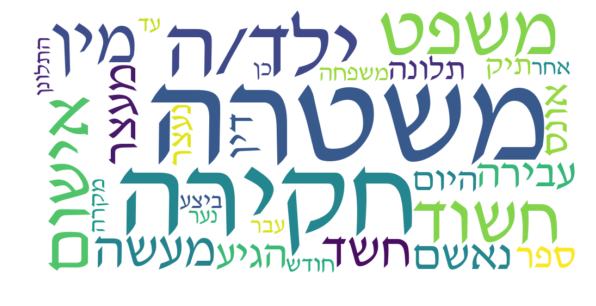

In [385]:
# build world cloud

### Option 1: Create word cloud from the word frequencies as found in the previous cell

def final_letter(word):
    '''A function that fixes the final letter of a word for the correct form
       because in Hebrew some letters are written differently in the end of a word'''
    if word.endswith('מ'):
        word = word[:-1]+'ם'

    elif word.endswith('כ'):
        word = word[:-1]+'ך'

    elif word.endswith('נ'):
        word = word[:-1]+'ן'

    elif word.endswith('פ'):
        word = word[:-1]+'ף'

    elif word.endswith('צ'):
        word = word[:-1]+'ץ'
        
    elif word.endswith('ילד'):
        word = word[:-1]+'ד/ה'
        
    return word

bidi_dict = {} # new dictionary for reversed keys (words) for presentation
for k,v in sorted_words.items():
    bidi_dict[get_display(final_letter(k))] = v # get_display from the bidi library for chaning the order

# create wordcloud object
wc1 = WordCloud(background_color="white", width=1000, height=500,
                font_path='david.ttf', max_words=30, min_font_size=8, 
                normalize_plurals=False).generate_from_frequencies(bidi_dict)

##
### Option 2: Create word cloud from the entire norm_words column as a chunk
## 

# # create a long bulk of text from the entire norm_words column
# all_words = ' '.join(clean_df.norm_words.values)

# # words to exclude when counting - 'of', 'his', 'with', etc.
# stopwords = ['את', ... (see above)
#                'כל']

# # convert text and words for left-to-write presentation
# bidi_text = get_display(all_words)
# bidi_stop = {get_display(w) for w in stopwords}

# create figure
plt.figure(figsize=(12,6))

# ### create word cloud object
# wc2 = WordCloud(background_color="white", width=1000, height=500,
#                font_path='david.ttf', stopwords=bidi_stop, max_words=30, 
#                min_font_size=8, normalize_plurals=False, regexp=None).generate_from_text(bidi_text)


# plot both
#plt.subplot(1,2,1)
plt.figure(figsize=(10,5))
#plt.title('From word frequncies')
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")

# plt.subplot(1,2,2)
# plt.title('From raw text column')
# plt.imshow(wc2, interpolation='bilinear')
# plt.axis("off")

plt.show()

In [313]:
# verify count is correct
sum(clean_df.norm_full_text.str.count('אונס')), sorted_words['אונס']

(258, 258)

#### Comments: Titles only
There are two options above - cloud from the raw text and from the word frequencies function. Looks like for some reason the raw text column word cloud is not accurate, because the frequency dictionary correctly identified the number of mentions of a word (rape - 112 above), but it was tiny when building the cloud with raw text. So I'm using the dictionary above.
 
The main thing that stands out here is that most words revolve around the criminal aspect of sexual assault: the largest ones (except for rape, 3rd most common) are suspect (male), allegations, child, arrest, sex, police, investigation, violation, criminal charges. These are followed by arrested, trial, defendant, criminal record. Given that this is just the titles, perhaps it's reasonable that criminal-legal terminology is there? Would it be better if there was more focus on the victim and what happened to here rather than reporting on the suspect first? Not sure.

To say something meaningful about the use of lenient terms that are not rape when it is a potential rape case will probably be hard - the cases that do not use this word will have to be looked quite closely, and I doubt I'll have some automated word-based way of knowing. 

#### Comments: Full text only
The same theme: police, charges, the criminal system. The top words are police, investigation, (kid), trial, suspect, charges, sexual, deed, suspicion, arrest, defendent, penalty, legal. All of these precede 'rape'.

interesting to compare kiyem, bitzua vs rape as a verb <--- actually should go to verbs

### 2. Lawyer mentions 
How much space is given to lawyers, and what messages are highlighted by featuring them?

In [324]:
legal = ['עורכ דינ',
        'ערכ דינ',
        #'פרקליט', removed because of praklitut spam
        'סנגור',
        'עו"ד']


# find number of legal words in each article
legal_words = clean_df['norm_words'].str.count('|'.join(legal))

print(f'Articles with some legal reference: {sum(legal_words > 0)} of {clean_df.shape[0]} articles')

Articles with some legal reference: 27 of 211 articles


In [51]:
# look at the content of these articles - a lot around one case of the 7yo and cyprus, 
# did not address them below because these were longer stories and both sides had different items

legal_indices = clean_df.index[legal_words>0].tolist()
for i in legal_indices:
    print(i, '\n', new_df.title.values[i] ,'\n', new_df.subtitle.values[i])

64 
 "חשודות, לא קורבנות": ביהמ"ש דן בחשיפת המעורבות בפרשת נוה 
 צו איסור הפרסום על פרטי השופטת ועו"ד מפרשת "מין תמורת מינוי" עדיין בתוקף וביהמ"ש המחוזי בת"א דן בערעור על הארכתו. "המערכת מאתרגת את בנותיה", טענה נציגת המערערים. "איך נחזיר את הגלגל לאחור?", שאל סנגורה של עורכת הדין. הצו הוארך עד לשבוע הבא
1149 
 במשך תקופה בלימודים: מורה חשוד שהטריד מינית תלמידות בתיכון בעכו 
 החשוד, תושב ג'דיידה-מכר בשנות ה-30 לחייו, נעצר היום לפנות בוקר. במהלך חיפוש שנערך בביתו נתפסו מחשב וטלפון נייד לצרכי חקירה. מעצר הוארך בבית משפט השלום בעכו עד ליום ראשון. סנגורו: "הוא מכחיש מכל ומכל"
1564 
 הקצינה צ' דורשת התנצלות מרוזן: "התבססת על רכילות משרדית זולה" 
 סנגוריה של קצינת המשטרה שנטען כי ניהלה מערכת יחסים קרובה עם המפכ"ל דנינו דרשו מנציב הביקורת על הפרקליטות להתנצל בפניה. עורכי הדין קבלו על כך שרוזן לא שמע את גרסתה של צ' במסגרת בדיקת החשדות. "מצייר את מרשתנו כאישה מופקרת שפילסה את דרכה דרך מיטתם של בכירים"
1643 
 סנגורי הנאשם באונס בזיקים: "הוא לא היה יכול למנוע את המעשה" 
 הוארך ב-7 ימים מעצרו של שח

#### Comments
Strong negative examples of bad practices: 1643, 2307, 2626, 2814

'He denies' but no voice for the victim: 1149, 1826, 2233, 2606, 2821, 3719, 3800, 4019, 4132

The lawyer of the victim: 1794, 1854, 1564, 2605, 2621, 3751, 3917

It appears to me that this part has the potential to feature some examples of the different types of coverage rather than perform some quantitative analysis on number of mentions etc. Show some examples were the victim's voice was highlighted and others that focused on the defendant, from 'denial' to worse ('he could not stop himself'... jesus). I might try to quantify this ratiom, but it might take some work and I'm not sure how strong will it be.

Maybe I could try to use these references to find what the lawyers are saying every time (if only they would always put it in quotation marks...) - then it would be easier to analyze these for the above questions. 

When looking at the whole text there is a lot more references - 128 out of 211 articles. Could potentially provide more mateiral, if I was able to effectively identify when which lawyer speaks.

### 3. Gendered verbs - what did both sides do?

#### A. Look at one article

In [120]:
# find all verbs in a given row (title+subtitle)
row_id = 11 # the row to look at

# a long string and an array of words for that row
original_text = clean_df.title.values[row_id]+' '+clean_df.subtitle.values[row_id]
original_words = original_text.split(' ')

# get result from API
request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
           'paragraph':  original_text}

result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# array to store rows for a little dataframe that shows the 
# verb, gender, and sentence context to look at results closely
verbs=[]
word_id = 0

# iterate over all words in the result
for sentence in result:
     for word in sentence:
        best_option = word[0] # get the best-guess normalized word 
        if len(best_option['baseWord']) <= 1: # ignore punctuation
            continue
            
        if best_option['partOfSpeech'] == 'VERB':
            new_verb = { # create a new row
                'normalized' : best_option['baseWord'], # the verb
                'gender': best_option['gender'], # the gender
                'context': (' ').join(original_words[ # context in sentence
                    max(0,word_id-3):min(word_id+3, len(original_words))])
                }
            
            # add the suffix for feminine verbs for easy read
            if new_verb['gender']=='FEMALE' and new_verb['normalized'][-1]!='ה':
                new_verb['normalized'] = new_verb['normalized']+'ה'
            verbs.append(new_verb)
        word_id+=1

pd.DataFrame(verbs) 

,normalized,gender,context
0,הדל,BOTH,שידלו בת 13
1,ביצע,NONE,שידלו בת 13 לבצע אקט מיני
2,נעצר,BOTH,בשידור חי: 17 נעצרו בחשד לפדופיליה
3,נעצר,BOTH,מכל רחבי הארץ נעצרו בפשיטת המשטרה
4,יצר,BOTH,"פי החשד, הם יצרו קשר עם"
5,התחזה,BOTH,"קשר עם שוטרים שהתחזו לנערה, נהגו"
6,נהג,BOTH,"שוטרים שהתחזו לנערה, נהגו להתכתב איתה"
7,התכתב,NONE,"שהתחזו לנערה, נהגו להתכתב איתה ולשלוח"
8,שלח,NONE,"נהגו להתכתב איתה ולשלוח לה תמונות,"
9,הדל,BOTH,"תוכן מיני בוטה, וכן שידלו אותה"


#### Comments 
1. One complication is that even though with adults 99% of cases have a male perpetrator and female victim, with children victims (which are, unfortunately, a subset of cases) there are some male victims, and more rarely, female perpetrators. I might try to count exactly how many of such cases to understand if it's significant or just stands out most clearly.
2. Verbs can sometimes be associated with lawyers, police, court (praklitut) - makes it harder. Although these might even out - some of these are masculine and some feminine. maybe i'll have to count these to make sure it does. not sure it's THAT worth it.
3. Misidentifications by the linguistic analyzer - the word for lawyer has an embedded verb in it. Can be removed after when looking at the list, though. I don't think I'll do anything else except for that + acknowledging it. It doesn't look like it happens very often.
4. If there are multiple offenders, the verb comes up as 'both' because it's not gendered in plural. So that's one reason to think that the male verbs results actually underestimate the true numbers. 

#### 3B. Find verbs in all articles

In [351]:
def get_all_terms(original_text, partOfSpeech):
    ''' Takes normalized text as a long string, and the part of speech to search of
        Returns to arrays, one for each gender, of the part of speech desired (e.g. verb)'''
    
    # array to hold results
    all_m_verbs, all_f_verbs = [], []
    
    for i in tqdm(range(len(original_text))):
        # get a result from API
        request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
                   'paragraph':  original_text[i]}

        result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

        # arrays to store verbs
        row_m_verbs=[]
        row_f_verbs=[]

        # iterate over all words in the result
        for sentence in result:
             for word in sentence:
                best_option = word[0] # get the best-guess normalized word 
                if len(best_option['baseWord']) <= 1: # ignore punctuation
                    continue

                if best_option['partOfSpeech'] == partOfSpeech: # if a verb, add to respective array
                    if best_option['gender'] =='MALE':
                        row_m_verbs.append(best_option['baseWord'])

                    # add the suffix for feminine verbs for easy read
                    elif best_option['gender'] =='FEMALE':
                        row_f_verbs.append(best_option['baseWord']+'ה')

        all_m_verbs.append(' '.join(row_m_verbs))
        all_f_verbs.append(' '.join(row_f_verbs))
        
    return all_m_verbs, all_f_verbs

### Titles
# a joint string for title and subtitle
#original_text = clean_df.title.values+' '+clean_df.subtitle.values

# array to store two new columns: all masculine/feminene verbs in the article
#all_m_verbs, all_f_verbs = get_all_terms(original_text, 'VERB')


In [354]:
# Get verbs for all articles using the above function
### Full article
full_original_text = clean_df.full_text.values

# array to store two new columns: all masculine/feminene verbs in the article
full_m_verbs, full_f_verbs = get_all_terms(full_original_text, 'VERB')

  1%|▏         | 3/211 [00:01<01:40,  2.07it/s]

 47%|████▋     | 99/211 [01:15<01:34,  1.19it/s]

100%|██████████| 211/211 [02:37<00:00,  1.34it/s]


In [404]:
# optionally, add that to the df as a column
# clean_df.loc[:,'m_verbs'] = all_m_verbs
# clean_df.loc[:,'f_verbs'] = all_f_verbs

# get a sorted version of verb occurences 
def get_sorted_counts(all_verbs):
    '''Takes in an array of strings that contain all verbs separated by whitespaces
    returns a sorted count dictionary across all elements in the input array'''
    verbs_counts= {} # holds the result

    # for each collection of words in a title+subtitle
    for wrds in all_verbs: 
        # create a count dictionary for it 
        keys, values = np.unique(wrds.split(' '), return_counts=True)
        temp_dict = dict(zip(keys, values))

        # add it to the total counter 'word_counts'
        verbs_counts = {key: verbs_counts.get(key, 0) + temp_dict.get(key, 0)
              for key in set(verbs_counts) | set(temp_dict)}

    verbs_counts.pop('') # remove an empty entry that gets created
    sorted_ = sorted(verbs_counts.items(), key=lambda x: x[1], reverse=True) # sort by frequency
    return(sorted_)

# get for male and female - titles
#m_sorted=np.array(get_sorted_counts(all_m_verbs))
#f_sorted=np.array(get_sorted_counts(all_f_verbs))

m_sorted=np.array(get_sorted_counts(full_m_verbs))
f_sorted=np.array(get_sorted_counts(full_f_verbs))

In [429]:
# explore results
rng=50
for n,txt in enumerate(m_sorted[:50]):
    print(n, txt)

0 ['נעצר' '173']
1 ['הגיע' '114']
2 ['ביצע' '107']
3 ['עבר' '104']
4 ['טענ' '99']
5 ['הכחיש' '86']
6 ['התלוננ' '70']
7 ['סיפר' '65']
8 ['עשה' '61']
9 ['ניסה' '58']
10 ['נראה' '56']
11 ['נמצא' '53']
12 ['קיבל' '48']
13 ['הורשע' '44']
14 ['שוחרר' '44']
15 ['ידע' '44']
16 ['עבד' '40']
17 ['שכב' '39']
18 ['ניצל' '38']
19 ['נהג' '38']
20 ['התברר' '37']
21 ['דובר' '37']
22 ['אנס' '37']
23 ['נערכ' '37']
24 ['האריכ' '36']
25 ['נכתב' '36']
26 ['ציינ' '35']
27 ['המשיכ' '34']
28 ['נגע' '34']
29 ['לקח' '33']
30 ['נחקר' '33']
31 ['הואשמ' '31']
32 ['הודה' '30']
33 ['הובא' '30']
34 ['מצא' '30']
35 ['נקבע' '30']
36 ['דחה' '29']
37 ['מינה' '29']
38 ['שימש' '28']
39 ['יצא' '28']
40 ['ראה' '28']
41 ['פעל' '27']
42 ['נעשה' '27']
43 ['התגורר' '27']
44 ['עמד' '27']
45 ['הטריד' '25']
46 ['הציע' '25']
47 ['קרא' '25']
48 ['שהה' '25']
49 ['שלח' '25']


In [407]:
# remove verbs that clearly do not talk about either person but the investigation or police
# or are generic like 'was' and 'said' (most frequent for both) - marked by index
m_remv = [0, 1, 2, 8, 9, 11, 12, 13, 15, 16, 18, 23, 24, 25, 27, 31, 32, 33, 34, 35, 37, 38]
f_remv = [0, 1, 4, 9, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 27, 31, 33]

# remove by index and covert to the same format - np array with elements (verb, count) 
m_sorted = np.array([(i[0],i[1]) for j, i in enumerate(m_sorted) if j not in m_remv])
f_sorted = np.array([(i[0],i[1]) for j, i in enumerate(f_sorted) if j not in f_remv])

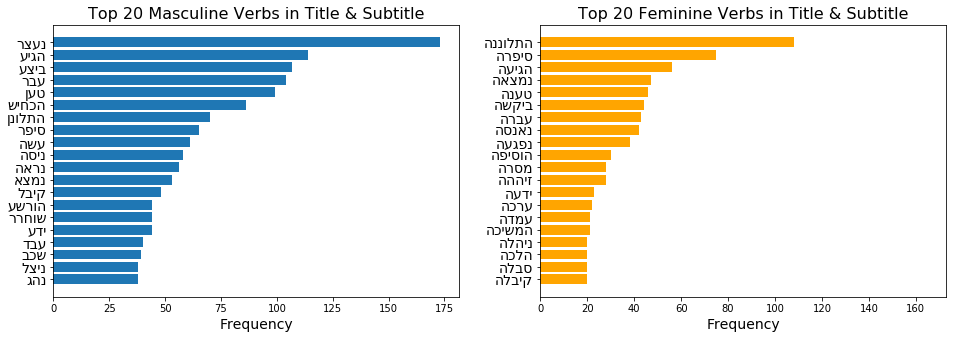

In [408]:
# print bar plots

def plot_sorted_fm(f_sorted, m_sorted, title, topN=20):
    # make lists with the verbs and frequencies
    m_verbs = [get_display(final_letter(_)) for _ in m_sorted[:topN,0]]
    m_counts = m_sorted[:topN,1].astype(int)

    f_verbs = [get_display(final_letter(_)) for _ in f_sorted[:topN,0]]
    f_counts = f_sorted[:topN,1].astype(int)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))

    # masculine
    ax1.barh(np.arange(len(m_verbs)), m_counts)
    ax1.set_yticklabels(m_verbs, fontsize=14)
    ax1.set_yticks(np.arange(len(m_verbs)))
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Frequency', fontsize=14)
    ax1.set_title(f'Top 20 Masculine {title} in Title & Subtitle', fontsize=16)

    # feminine
    ax2.barh(np.arange(len(f_verbs)), f_counts, color='orange')
    ax2.set_xlim(0,max(m_counts))
    ax2.set_yticklabels(f_verbs, fontsize=14)
    ax2.set_yticks(np.arange(len(f_verbs)))
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_title(f'Top 20 Feminine {title} in Title & Subtitle', fontsize=16)
    plt.show()
    
plot_sorted_fm(f_sorted, m_sorted, 'Verbs')

In [426]:
sum(clean_df.full_text.str.count('אנס ')), sum(clean_df.full_text.str.count('אונס'))
# interesting results with the frequency of rape as noun and as verb for men - less than 'slept'.
# if there is rape suspicion, use 'raped'.

(56, 265)

Using 'raped' verb:

There were 265 mentions of rape as a noun, but 37 usages as a verb, which is less than the passive feminine 'was raped'. Conversely, the words 'committed' appeared 107 times, which is used in a way of 'commited the actions he is suspect of', or just 
'he is suspected with rape' . Even the masculine verb 'slept' appeared 39 times. This also stood out when looking only at the titles (can show that one too). If there is alleged rape, then it should be made clear that the suspect has allegedly raped someone, not 'committed' or 'did' or that the woman 'was raped'. Unfortunately, the part-of-speech analyzer doesn't allow to aggregate counts of passive and active.

In [431]:
# show all mentions of a word in an article text
for i,txt in enumerate(clean_df.full_text.values):
    if 'אנס ' not in txt and 'אונס' in txt:
        print(i, txt)

1 תושבי שכונת הדר יוסף דיווחו על הפדופיל בקבוצת הווטסאפ השכונתית, לאחר שתקף ילדה וצעירה בסמיכות זמנים ובאותו אזור. גננת שהבחינה בו בסמוך לגן בו עבדה - הזעיקה את המשטרה. בתום חקירה הוא הובא להארכת מעצר אסירים לבנונים ברחו מהכלא ונהרגו בתאונת דרכים פדופיל נעצר סמוך לגן ילדים בשכונת הדר יוסף בתל אביב השבוע והיום (שלישי) יובא להארכת מעצרו בבית משפט. על פי החשד, האדם תקף ילדה בת 11 וצעירה מהשכונה בסמיכות זמנים ובאותו האזור. תושבי השכונה העבירו בימים האחרונים את תיאור האדם בקבוצת הווטסאפ השכונתית והתושבים התגייסו לחיפושים. גננת שעובדת בגן ילדים בהדר יוסף, קראה את תיאורו של האדם והבחינה בו בסמוך לגן שבו היא עובדת. הגננת  הזעיקה את המשטרה, ושוטרי משטרת תל אביב צפון הגיעו למקום, עצרו את החשוד, והוא נלקח לחקירה. לקריאה נוספת: בתחילת החודש המשטרה עצרה 13 חשודים בעבירות פדופיליה שנחשפו בעזרת סוכנת סמויה של המשטרה. העצורים חשודים בעבירות של הטרדה מינית, ומעשים מגונים בילדה בת 14 וחלקם אף נעצרו בחשד לניסיון אונס תוך שהם מודעים לגיל הצעיר של הילדה. אחד העצורים הוא עוזר אפסנאי בקבוצת מכבי תל אביב בכדו

In [409]:
# Total number of M vs F

# this is hard to interpret even after I removed some verbs because I didn't do it comprehensively 
# but generally, the police and state (who press charges) are feminine, while the court is masculine, 
# so I estimate the gap in 'who's the focus' is at least as big.
# Need to verify whether childen cases would change things much

sum(m_sorted[:,1].astype(int)), sum(f_sorted[:,1].astype(int))
#print('All masculine verbs: \n',[(final_letter(_)) for _ in m_sorted[:,0]])
#print('All feminine verbs: \n',[(final_letter(_)) for _ in f_sorted[:,0]])

(5868, 2759)

#### Comments:

A lot more masculine verbs, I suspect even after accounting for the challenges described above. That's a very big gap.

I should remove some that no way relate to individuals. (Walked, killed...)

...

### 4. Gendered adjectives - how are perpetrator/victim described?

Main challenge here is that often they aren't described via adjective, but more in the main body of text via descriptions of their background, career, etc. So that's not going to be in the title.

In [442]:
# Get all masculine / feminine adjectives - titles
#all_m_adj, all_f_adj = get_all_terms(original_text, 'ADJECTIVE')

# full text
full_m_adj, full_f_adj = get_all_terms(full_original_text, 'ADJECTIVE')

# Get counts and sort
m_sorted_adj=np.array(get_sorted_counts(full_m_adj))
f_sorted_adj=np.array(get_sorted_counts(full_f_adj))

In [443]:
# change to the corrent suffix for feminine adjectives
for i in range(len(f_sorted_adj)):
    f_sorted_adj[i][0] = f_sorted_adj[i][0][:-1] + 'ת'

In [449]:
# explore results
rng=50
for n,txt in enumerate(m_sorted_adj[100:150]):
    print(n, txt)

0 ['פשוט' '7']
1 ['חי' '6']
2 ['עצוב' '6']
3 ['אכזרי' '6']
4 ['כבד' '6']
5 ['יהודי' '6']
6 ['נדרש' '6']
7 ['מדובר' '6']
8 ['עיקרי' '6']
9 ['מדויק' '6']
10 ['פלסטיני' '6']
11 ['אמריקני' '6']
12 ['יוני' '6']
13 ['עשיר' '6']
14 ['עמוק' '6']
15 ['מקורי' '6']
16 ['סניגורי' '6']
17 ['חשופ' '6']
18 ['מורכב' '6']
19 ['מתואר' '6']
20 ['ישיר' '5']
21 ['קליט' '5']
22 ['כספי' '5']
23 ['אנונימי' '5']
24 ['כולל' '5']
25 ['אוראלי' '5']
26 ['מתקדמ' '5']
27 ['מוגנ' '5']
28 ['טכנולוגי' '5']
29 ['סמוי' '5']
30 ['נחרצ' '5']
31 ['ארוכ' '5']
32 ['קדמי' '5']
33 ['נורמטיבי' '5']
34 ['מבוסס' '5']
35 ['מוסמכ' '5']
36 ['משמעתי' '5']
37 ['תיכונ' '5']
38 ['צריכ' '5']
39 ['גבה' '5']
40 ['דומה' '5']
41 ['בודד' '5']
42 ['עצומ' '5']
43 ['נמרצ' '5']
44 ['יפה' '4']
45 ['אירופי' '4']
46 ['סלולרי' '4']
47 ['ימי' '4']
48 ['מוערכ' '4']
49 ['רציני' '4']


In [213]:
# Remove things 

# remove verbs that clearly do not talk about either person - marked by index
m_remv_adj = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,29,30,31,32,34,33,37,38,40,
             41,42,43,44,45,46,47,49,50,51,53,55,58,59,]
f_remv_adj = [1, 3, 4, 5]

# remove by index and covert to the same format - np array with elements (verb, count) 
m_sorted_adj = np.array([(i[0],i[1]) for j, i in enumerate(m_sorted_adj) if j not in m_remv_adj])
f_sorted_adj = np.array([(i[0],i[1]) for j, i in enumerate(f_sorted_adj) if j not in f_remv_adj])

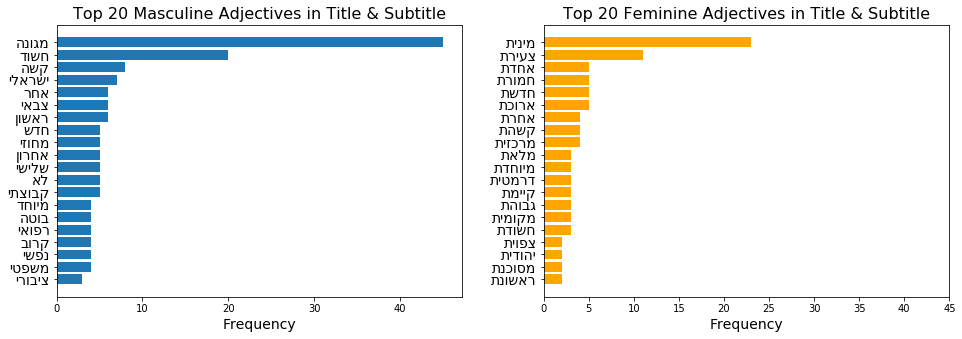

In [218]:
plot_sorted_fm(f_sorted_adj, m_sorted_adj, 'Adjectives')

In [481]:
# show all mentions of a word in an article text
for i,txt in enumerate(clean_df.full_text.values):
    if 'שתתה' in txt:
        print(i, txt)
        print()

32 שטייף, עיתונאית גלי צה"ל, תפצה את זהבי לאחר שטענה שהטריד מינית. שדרן הרדיו הגיש נגדה תביעת לשון הרע בשל הפרסום, ובית משפט השלום בתל אביב החליט לקבל את התביעה. זהבי בריאיון הבוקר: "יש שופטות בתל אביב. שטייף היא שקרנית, לא אמינה" עיתונאית גלי צה"ל הדס שטייף תפצה את איש התקשורת נתן זהבי ב-390 אלף שקלים, לאחר שטענה שהטריד מינית. זהבי הגיש נגד שטייף תביעת לשון הרע בשל הפרסום, והיום (ראשון) החליטה שופטת בית משפט השלום בתל אביב, אושרי פרוסט פרנקל, לקבלה.כתבתה של שטייף פורסמה בנובמבר 2017, ובעקבותיה הגיש זהבי תביעה בסך 1.8 מיליון שקלים - כלומר, פיצוי של 140 אלף שקל עבור כל אחד מ-13 הפרסומים של שטייף נגדו. בנוסף, דרשו עורכי דינו כי שטייף תתנצל - הצעה שדחתה גם במהלך המשפט. היום קבעה השופטת פרוסט-פרנקל כי כל אחד מהפרסומים מהווה לשון הרע, ופסקה את הפיצוי הגבוה.עוד באותו נושא היום, לאחר הקראת פסק הדין, צייצה שטייף בטוויטר: "יצאתי באמצע הקראה של זהבי נגד שטייף. שבע עדות הגיעו. מדם לבן סיפרו את סיפורן... השופטת כנראה לא היתה בדיונים ... אני עדיין בשוק. טרם הסתיים. זה שצעירות באות ומספרות מה קרה לה

#### Comments
After looking at all male ones, most of the most frequent ones are not clearly about the person. So might be worth searching for specific words and exploring them.

Intimate (pictures or body parts), (gorem / katzin) bahir, (mosad) hinuhi, professional (n/a) , good (1 bney tovim-152), normative (205, 128, 134, 2 - although all quotes), muarach (187, 183, 124, 46)

These are not very prevalent, but I'm sure there are other similar cases that I did not catch. 

lawyer responses are most infuriating, but also, should there be no room for them to say they deny allegations? Maybe only after case is decided?

### Save to text file

In [378]:
# save text files 
for i,text in enumerate(clean_df.full_text.values):
    fname = f'textfiles/file{i+1}.txt'
    if len(text)>0: # weird error in some reports
        with open(fname, "w", encoding="utf-8") as f:
            f.write(text)

# ----------------------------------------Playground----------------------------------------

More analysis later:

search mentions of 'drank', 'wore', 'drunk' --> quick search did not yield much

can't search what was the subject of a sentence, sadly

### how many times the victim is the subject of the sentence, rather then the defendant? Is that too weak to serve as an approximation of whose voice is heard?

### look at lenient terminology

for both gender cases - be careful with children cases

### Testing HebrewNLP - Tokenize, Normalize, Analyze

In [236]:
# Tokenize - separate text to words and nikud.

request = {
    'token': 'EGxhAVjlYSoRNsN',
    'text': clean_df.subtitle.values[48]
}

result = requests.post('https://hebrew-nlp.co.il/service/preprocess/tokenizer', json=request).json()

print(clean_df.subtitle.values[48])
print(result)

חוקרי ימ"ר תל אביב פשטו על דירותיהם של שני תושבי העיר שחשודים כי הפעילו את האתר DW, ששימש לעסקאות סמים ולהעברת חומרי פדופיליה. בפריז נעצר חשוד ישראלי שלישי, בסיום חקירה משותפת ל-FBI וליחידות שונות ברחבי העולם. מרבית העסקאות בוצעו בעזרת מטבע וירטואלי
[['חוקרי', 'ימ"ר', 'תל', 'אביב', 'פשטו', 'על', 'דירותיהם', 'של', 'שני', 'תושבי', 'העיר', 'שחשודים', 'כי', 'הפעילו', 'את', 'האתר', 'DW', ',', 'ששימש', 'לעסקאות', 'סמים', 'ולהעברת', 'חומרי', 'פדופיליה', '.'], ['בפריז', 'נעצר', 'חשוד', 'ישראלי', 'שלישי', ',', 'בסיום', 'חקירה', 'משותפת', 'ל', '-', 'FBI', 'וליחידות', 'שונות', 'ברחבי', 'העולם', '.'], ['מרבית', 'העסקאות', 'בוצעו', 'בעזרת', 'מטבע', 'וירטואלי']]


In [461]:
# Hebrew-NLP Normalize - also runs sentencer and tokenizer
# -- it turns numbers into a #
# -- nikud is a problem with this one

test_text = ['אנס', 'באונס', 'שנאנסה']
request = {
    'token': 'EGxhAVjlYSoRNsN',
    # Normalize:
    'type': 'SEARCH',
    'sentences': test_text # text if full text
}

result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Normalize', json=request).json()

print(result)
'אנס' in result

[['אֹנֶס', '.'], ['אֹנֶס', '.'], ['נֶאֱנַס', '.']]


False

In [437]:
# Hebrew-NLP Analyze


#relevant_words = 'עורך דין פרקליט סנגור עו"ד '
relevant_words = 'החשוד תקף את הנערה, הנערה נאנסה על ידי החשוד'
request = {
    'token': 'EGxhAVjlYSoRNsN',
    'readable': False,
    'paragraph':  relevant_words
}

result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

for sentence in result:
    for word in sentence:
        best_option = word[0]
        print(f"{best_option['baseWord']} - {best_option['partOfSpeech']}") 

חשוד - NOUN
תקפ - VERB
את - PREPOSITION
נערה - NOUN
, - PUNCTUATION
נערה - NOUN
נאנס - VERB
על - PARTICLE
ידי - PARTICLE
חשוד - NOUN
. - PUNCTUATION


In [439]:
# Examine the type of information recieved per word
# -- can access both with and without nikud
# -- gender
result[0][1][0] , result[0][6][0]

({'baseWord': 'תקפ',
  'baseWordMenukad': 'תָּקַפ',
  'constructState': 'NONE',
  'definiteArticle': False,
  'gender': 'MALE',
  'ownershipGender': 'NONE',
  'ownershipPerson': 'NONE',
  'ownershipPlural': False,
  'partOfSpeech': 'VERB',
  'person': 'THIRD',
  'plural': False,
  'prepositionChars': 'NONE',
  'subordination': 'NONE',
  'tense': 'PAST',
  'vav': False},
 {'baseWord': 'נאנס',
  'baseWordMenukad': 'נֶאֱנַס',
  'constructState': 'NONE',
  'definiteArticle': False,
  'gender': 'FEMALE',
  'ownershipGender': 'NONE',
  'ownershipPerson': 'NONE',
  'ownershipPlural': False,
  'partOfSpeech': 'VERB',
  'person': 'THIRD',
  'plural': False,
  'prepositionChars': 'NONE',
  'subordination': 'NONE',
  'tense': 'PAST',
  'vav': False})

In [381]:
# # experiment with a sample page 
# #pages = ['https://news.walla.co.il/archive/1?year=2020&month=3&page=2'] #this replaces the while loop
# #page = requests.get(pages[0], headers= headers)

# # make an empty array for the data
# rows = []

# #iterate through all the pages we've collected in the previous code cell.
# for url in tqdm(pages):
#     scrape_content(url) # the result is appending rows.append(row) - change 
    
# #writing list of dictionaries into a datafrme
# df = pd.DataFrame(rows) 

# #preview!
# df.head()

In [370]:
# might be useful to use the above code to save the corpus and export to Voyant or something
# for an exploratory analysis
clean_df.iloc[34,]

date                                               13:57 03/04/2019
title             חשד לעבירות מין בתלמידים: מורה לפסנתר בן 27 מה...
subtitle          המשטרה עצרה את בעז ליובין, תושב תל אביב ,לאחר ...
reporter                                                 אבי אשכנזי
link                          https://news.walla.co.il/item/3228461
norm_words        חשד עבירה מינ תלמיד מורה פסנתר שרונ נעצר משטרה...
full_text                                                          
norm_full_text                                                     
Name: 1293, dtype: object